In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import math

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from datetime import datetime


device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [2]:
# ----------------------- Setup ----------------------------
PATH_GENERATED = './generated/'

vocab = torch.load(PATH_GENERATED + 'vocabulary.pt', map_location=torch.device(device))
embedding = torch.load(PATH_GENERATED + 'embedding.pt', map_location=torch.device(device))
(VOCAB_SIZE, embedding_dim) = embedding.weight.shape  

words_train = torch.load(PATH_GENERATED + "words_train.pt", map_location=torch.device(device))
words_val   = torch.load(PATH_GENERATED + "words_val.pt", map_location=torch.device(device))
words_test  = torch.load(PATH_GENERATED + "words_test.pt", map_location=torch.device(device))

In [3]:
CONTEXT_SIZE = 10
conjugation_list = ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
MAP_TARGET = {vocab[w]:i for i, w in enumerate(conjugation_list)}

def create_dataset(text, vocab, context_size=CONTEXT_SIZE, map_target=MAP_TARGET):
    
    # Transform each word to its index in the vocabulary.
    txt = [vocab[w] for w in text]

    n_text = len(text)
    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        t = txt[i + context_size]
        if  not vocab.lookup_token(t) in conjugation_list: continue # We only want to guess conjunctions of be and have.
        c = txt[i:i + context_size]
        
        targets.append(map_target[t]) 
        contexts.append(torch.tensor(c).to(device=device))
            
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets).to(device=device)
    return TensorDataset(contexts, targets)

In [4]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname, map_location=torch.device(device))
    else:
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_conj = load_dataset(words_train, vocab, "conj_data_train.pt")
data_val_conj   = load_dataset(words_val, vocab, "conj_data_val.pt")
data_test_conj  = load_dataset(words_test, vocab, "conj_data_test.pt")

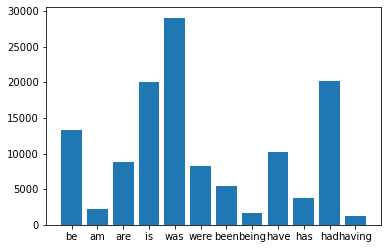

In [5]:
counts = Counter(data_train_conj[:][1].tolist())
values = [int(counts[i]) for i in range(len(counts))]
plt.bar(conjugation_list, values)
plt.show()

The distribution of the target words are very skewed, we need to weigh the words by their frequency in the training set

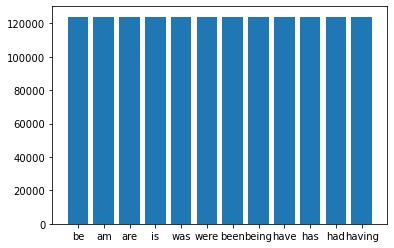

In [6]:
def calculate_word_weights(values):
    """
    Calculate the weight of each word so that the loss function can weigh 
    frequent words less and unfrequent words more.
    """
    total_words = sum(values)
    word_weights = [total_words / value for value in values]
    word_weights = torch.tensor(word_weights, dtype=torch.float).to(device=device)
    return word_weights

word_weigts = calculate_word_weights(values)
values_balanced = [int(values[i])*w for i, w in enumerate(word_weigts)]
plt.bar(conjugation_list, values_balanced)
plt.show()

In [215]:
# ---------------- Attention functions -----------------------
pos_encoding = torch.zeros((CONTEXT_SIZE, embedding_dim))
for i in range(CONTEXT_SIZE):
    for ii in range(int(embedding_dim/2)):
        pos_encoding[i][2*ii] = math.sin(i/1000**((2*ii)/embedding_dim))
        pos_encoding[i][2*ii +1] = math.cos(i/1000**((2*ii)/embedding_dim))

In [222]:
# ---------------- Simple MLP hyper parameters -----------------------
lrs = [0.01, 0.001]
decays = [0.8, 0.5, 0.1]
mlp_hparams = [{
    'lr': lr,
    'weight_decay': decay
} for lr in lrs for decay in decays]

# ---------------- Attention MLP hyper parameters ----------------------- TEMP
lrs = [0.1, 0.01, 0.001]
attention_hparams = [{
    'lr': lr,
} for lr in lrs]

# ---------------- RNN MLP hyper parameters ----------------------- TEMP
lrs = [0.01, 0.001]
rnn_hparams = [{
    'lr': lr,
} for lr in lrs]

hparams = []
hparams.append(mlp_hparams)
hparams.append([None]) #TODO temp

In [10]:
# ---------------- Train and accuracy -----------------------
def train(n_epochs, optimizer, model, loss_fn, train_loader):

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

def compute_accuracy(model, loader):
    """
    Computes accuracy as correctly predicted / total 
    """
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += len(targets)
            correct += int((predicted == targets).sum())

    acc =  correct / total
    return acc

In [220]:
class SimpleMLP(nn.Module):
    def __init__(self, embedding, context_size=CONTEXT_SIZE):
        super().__init__()

        (vocab_size, embedding_dim) = embedding.weight.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.fc1 = nn.Linear(embedding_dim*context_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)

    def forward(self, x):
        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

class AttentionMLP(nn.Module):
    def __init__(self, batch_size=256, n_heads=5):
        super().__init__()

        self.n_heads = n_heads
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.W_q = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_k = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_v = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_o = nn.Parameter(torch.rand((embedding_dim, self.n_heads * CONTEXT_SIZE)))

        self.fc1 = nn.Linear(embedding_dim*CONTEXT_SIZE, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)
    
    def forward(self, x):
        batch_size, _ = x.size()
        x = self.embedding(x)
        x = x + pos_encoding
        
        multi_attn_heads = []
        for ii in range(CONTEXT_SIZE):
            attn_heads = torch.empty(0)
            for i in range(self.n_heads):
                q = x[:,ii,:] @ self.W_q[i].T
                k = x[:,ii,:] @ self.W_k[i].T 
                v = x[:,ii,:] @ self.W_v[i].T
                
                attn_weights = torch.stack([q[j] @ k[j].T for j in range(batch_size) ])
                attn_weights = torch.softmax(attn_weights / math.sqrt(CONTEXT_SIZE), dim=-1)
                attn_head = torch.unsqueeze(attn_weights, dim=1) * v
                attn_heads = torch.cat((attn_heads, attn_head), 1)
            multi_attn_heads.append(self.W_o @ attn_heads.T)
       
        multi_attn_heads = torch.stack(multi_attn_heads)
        out = multi_attn_heads.permute(2, 0, 1)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        

In [224]:
def train_models(hparams):
    mlp_hparams, _ = hparams
    
    train_losses = []
    models = []
    accuracies = []

    print("Now training a simple MLP model")
    for param in mlp_hparams:
        print(f"Training using parameters: {param}")
        model = SimpleMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        train_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)
        val_loader = DataLoader(data_val_conj, batch_size=128, shuffle=True)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
        accuracy = compute_accuracy(model, val_loader)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        print()

    print("Now training a MLP model with attention")
    for param in attention_hparams:
        print(f"Training using parameters: {param}")
        model = AttentionMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        train_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)
        val_loader = DataLoader(data_val_conj, batch_size=128, shuffle=True)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader)
        accuracy = compute_accuracy(model, val_loader)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        print()
    
    
    return models, train_losses, accuracies

models, train_losses, accuracies = train_models(hparams)

Now training a simple MLP model
Training using parameters: {'lr': 0.01, 'weight_decay': 0.8}
16:17:48.253302  |  Epoch 1  |  Training loss 2.48206
16:17:48.598952  |  Epoch 5  |  Training loss 2.48074
16:17:49.010302  |  Epoch 10  |  Training loss 2.48088

Training using parameters: {'lr': 0.01, 'weight_decay': 0.5}
16:17:49.113969  |  Epoch 1  |  Training loss 2.48095
16:17:49.454666  |  Epoch 5  |  Training loss 2.47925
16:17:49.837388  |  Epoch 10  |  Training loss 2.47889

Training using parameters: {'lr': 0.01, 'weight_decay': 0.1}
16:17:49.930799  |  Epoch 1  |  Training loss 2.47463
16:17:50.252930  |  Epoch 5  |  Training loss 2.47040
16:17:50.657184  |  Epoch 10  |  Training loss 2.46892

Training using parameters: {'lr': 0.001, 'weight_decay': 0.8}
16:17:50.758534  |  Epoch 1  |  Training loss 2.48178
16:17:51.115362  |  Epoch 5  |  Training loss 2.48106
16:17:51.484919  |  Epoch 10  |  Training loss 2.48069

Training using parameters: {'lr': 0.001, 'weight_decay': 0.5}
16:17

In [200]:
# Define the input tensors
x = torch.rand((2,3,4))
y = torch.rand((2,3,4))

z = [x, y]
z = torch.stack(z, dim=2)
print(x.size(), y.size(), z.size())

torch.Size([2, 3, 4]) torch.Size([2, 3, 4]) torch.Size([2, 3, 2, 4])


In [197]:
z

tensor([[[[0.9160, 0.8294, 0.4930, 0.2672],
          [0.9036, 0.4186, 0.5404, 0.7261],
          [0.3454, 0.4073, 0.9920, 0.2930]],

         [[0.8204, 0.1322, 0.0439, 0.7257],
          [0.9570, 0.4470, 0.4745, 0.9710],
          [0.1387, 0.8025, 0.5025, 0.8648]]],


        [[[0.6423, 0.4596, 0.4643, 0.3905],
          [0.7047, 0.6351, 0.6018, 0.8730],
          [0.8952, 0.6704, 0.9411, 0.8374]],

         [[0.6498, 0.3961, 0.1706, 0.3020],
          [0.5616, 0.4951, 0.1619, 0.4597],
          [0.1409, 0.8088, 0.7118, 0.0246]]]])

In [128]:
z.size()

torch.Size([128, 128])